In [1]:
from itertools import permutations as perms
from itertools import product
import numpy as np
from numpy.linalg import inv
import MultiPoint as mp
import propagator 

import imp  # imp.reload(module)
import matplotlib.pyplot as plt
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [2]:
class phi_tilde:    
    def __init__(self,k=[1,0,0],alpha=0,l=0,m=0):
        self.k=k
        self.alpha=alpha
        self.l=l
        self.m=m

In [3]:
def s2wlc_2(pset, N, FA, K):
    s2 = np.zeros((4,4),dtype=type(1+1j))
    k1=np.array([0,0,1])*K
    k2=-k1

    basis=[{'alpha':0,'l':0},
           {'alpha':1,'l':0},
           {'alpha':0,'l':2},
           {'alpha':1,'l':2}]
    
    #if norm(k1) < 1e-5:
    #    raise ValueError('Note sure if this is OK')

    for ii in range(0,4):
        for jj in range(ii,4):
            phi1 = phi_tilde(k1,**basis[ii])
            phi2 = phi_tilde(k2,**basis[jj])
            s2[ii,jj] = twoPointCorr(pset, N, FA, phi1, phi2)
            s2[jj,ii]=s2[ii,jj] # save time on symmetric

    return s2

$$
\sum_{orders}\int_{0}^{N}ds_{2}\int_{0}^{s_{2}}ds_{1}\delta_{\alpha_{1}\alpha\left(s_{1}\right)}\delta_{\alpha_{2}\alpha\left(s_{2}\right)}\mathcal{G}_{l_{1},l_{2}}^{m_{1}}\left(\vec{k}_{1},s_{2}-s_{1}\right)
$$

In [4]:
def twoPointCorr(pset,N,FA,phi1,phi2):
    val = 0.0+0.0j
    for ordered in perms([phi1,phi2]):
        q1=-ordered[0].k

        # chemical sequence
        sequence = (ordered[0].alpha,ordered[1].alpha)
        
        # Calculate or look up eigenstuff
        p = pset.get_vec_prop(q1)
        
        # Calculate time ordered intigral
        val += I2N(N,FA,p.prop(0),ordered[0].l,ordered[1].l,\
                    sequence)
    return val

$$
\int_{0}^{N}ds_{2}\int_{0}^{s_{2}}ds_{1}\delta_{\alpha_{1}\alpha\left(s_{1}\right)}\delta_{\alpha_{2}\alpha\left(s_{2}\right)}\mathcal{G}_{l_{1},l_{2}}^{m_{1}}\left(\vec{k}_{1},s_{2}-s_{1}\right)
$$

In [5]:
def I2N(N, FA, p1,lam0,lam, sequence):    
    if sequence == (0,0): # AA
        value = mp.IAAswitch(N,FA,lam0,lam,p1)
    elif sequence ==(0,1): # AB
        value = mp.IABswitch(N,FA,lam0,lam,p1)
    elif sequence == (1,1): # BB
        value = mp.IAAswitch(N,1-FA,lam0,lam,p1)
    else:
        value=0.0
    return value

In [6]:
def chiMtrx(xAA,xAB,xBB,xl2):
    return np.array( [[xAA, xAB, 0.0, 0.0 ],\
                      [xAB, xBB, 0.0, 0.0 ],\
                      [0.0, 0.0, xl2, xl2 ],\
                      [0.0, 0.0, xl2, xl2 ]])

$$2\left(\chi'_{\alpha_{1}\alpha_{2}}\right)_{l_{1}l_{2}}^{m_{1}m_{2}}+N\frac{1}{\bar{\phi}_{p}Al_{K}}\left(S'^{\left(2\right)}\right)^{-1}\delta_{m_{1}m_{2}}+\delta_{l_{1},0}\delta_{l_{2},0}\frac{1}{\bar{\phi}_{s}v_{s}}$$

In [7]:
def getGam(S,xAA=0.0,xAB=0.0,xBB=0.0,xl2=0.0,N=10.0,phiS=0.000001,vp=1.0,vs=1.0):
    phiP=1.0-phiS
    mtrx = np.array([[1.0, 1.0, 0.0, 0.0 ],\
                     [1.0, 1.0, 0.0, 0.0 ],\
                     [0.0, 0.0, 0.0, 0.0 ],\
                     [0.0, 0.0, 0.0, 0.0 ]])
    Gam=2*chiMtrx(xAA,xAB,xBB,xl2) + (N/(phiP*vp))*inv(S) + (1.0/(phiS*vs))*mtrx
    return Gam

In [8]:
# Find the eigenvectors of Gamma
# sorted by increasing eigenvalues
def getEigVV(S,parameters):
    Gam=getGam(S,**parameters)
    eigenValues, eigenVectors = np.linalg.eig(Gam)
    idx = (eigenValues.real).argsort()[::]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues, eigenVectors

# Search Methode

In [9]:
# Find the zero of a decreasing function
def findZero(fun,args,guess=1,tol=10**-10):
    lower=0
    while True:
        if fun(guess,*args)> 0.0:
            guess=guess*2.0
            if guess>10*100:
                return np.inf
        else:
            upper=guess
            break
    while upper-lower>tol:
        test=(upper+lower)/2
        if fun(test,*args)> 0.0:
            lower=test
        else:
            upper=test
    return test

In [67]:
def firstUnstable(xfun,FA,N,pset,display=False,guess=1.0,\
                  instabilitiesK=False,returnKinfo=False):
    # -------
    # Find x that instability for each k value
    # -------
    nkpts=100
    KV = np.logspace(-3,2,nkpts)
    x=np.zeros(nkpts)*np.NaN
    for ii in range(0,nkpts):
        S=s2wlc_2(pset, N, FA, KV[ii])
        x[ii] = findZero(xfun,[S],guess=guess)
    # You could implement a local search over k here ...
    
    # -------
    # Return info at instability of each K
    #--------
    if instabilitiesK:
        Slist=[]
        eigVectorList=[]
        for ii in range(0,nkpts):
            S=s2wlc_2(pset, N, FA, KV[ii])
            parameters = xfun(x[ii],S,returnValues=True)
            eigenValues, eigenVectors = getEigVV(S,parameters)
            Slist.append(S)
            eigVectorList.append(eigenVectors[:,0])
        return KV,x,eigenVectors
    
    # ------
    # Get info for the first unstabel K value
    # ------
    ii=np.argmin(x)
    x=x[ii]
    K=KV[ii]
    S=s2wlc_2(pset, N, FA, KV[ii])
    if np.isinf(x):
        print('No x value searched was unstable!')
        raise ValueError('x=inf')
    parameters = xfun(x,S,returnValues=True)
    eigenValues, eigenVectors = getEigVV(S,parameters)
    chi = chiMtrx(parameters['xAA'],parameters['xAB'],parameters['xBB'],parameters['xl2'])

    # -------
    # Return info at each K at x of first unstable K
    #--------
    if returnKinfo:
        minii=ii
        Slist=[]
        eigVectorList=[]
        eigValueList=[]
        for ii in range(0,nkpts):
            S=s2wlc_2(pset, N, FA, KV[ii])
            parameters = xfun(x,S,returnValues=True)
            eigenValues, eigenVectors = getEigVV(S,parameters)
            Slist.append(S)
            eigVectorList.append(eigenVectors[:,0])
            eigValueList.append(eigenValues[0])
        return KV,x,minii,eigValueList,eigVectorList    
    
    # -------
    # Print out info at unstable K value
    # -------
    if display:
        print('K',K)
        print('chi')
        print(chi)
        print('eigenValues')
        print(eigenValues.real)
        print('eigenVector')
        print(eigenVectors[:,0].real)
        print('S')
        print(S.real)
    return {'K':K,'chi':chi, 'eigVec':eigenVectors[:,0],'x':x}

In [11]:
# Returns the lowest eigenvalue of Gamma
def lowestEig(S,para):
    eigenValues, eigenVectors = getEigVV(S,para)
    return eigenValues[0]

# Melt

In [13]:
pset=propagator.prop_set(nlam=3)

## Some example parameter sets

In [14]:
def nearMelt(x,S,returnValues=False):   
    para={\
    'xAA':0.0,\
    'xAB':x,\
    'xBB':0.0,\
    'xl2':0.0,\
    'N':1.0,\
    'phiS':0.05,\
    'vp':1.0,\
    'vs':1.0\
          }
    if returnValues:
        return para
    return lowestEig(S,para)

In [15]:
N=nearMelt(0,0,True)['N']
FA=0.5
stuff = firstUnstable(nearMelt,FA,N,pset,display=True)

K 8.1113083079
chi
[[ 0.          3.33971971  0.          0.        ]
 [ 3.33971971  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
eigenValues
[  4.59878021e-11   1.44180369e+01   1.51486861e+01   5.59810754e+01]
eigenVector
[ 0.7053179  -0.7053179   0.05026592 -0.05026592]
S
[[ 0.17622468  0.01863188 -0.03594474 -0.04717591]
 [ 0.01863188  0.17622468 -0.04717591 -0.03594474]
 [-0.03594474 -0.04717591  0.08700971  0.01636971]
 [-0.04717591 -0.03594474  0.01636971  0.08700971]]


In [16]:
def nearMelt(x,S,returnValues=False):   
    para={\
    'xAA':0.0,\
    'xAB':x,\
    'xBB':0.0,\
    'xl2':1.0,\
    'N':1.0,\
    'phiS':0.05,\
    'vp':1.0,\
    'vs':1.0\
          }
    if returnValues:
        return para
    return lowestEig(S,para)

In [17]:
N=nearMelt(0,0,True)['N']
FA=0.5
stuff = firstUnstable(nearMelt,FA,N,pset,display=True)

K 8.1113083079
chi
[[ 0.          3.33971971  0.          0.        ]
 [ 3.33971971  0.          0.          0.        ]
 [ 0.          0.          1.          1.        ]
 [ 0.          0.          1.          1.        ]]
eigenValues
[  4.59960222e-11   1.51486861e+01   1.83034293e+01   5.60956829e+01]
eigenVector
[ 0.7053179  -0.7053179   0.05026592 -0.05026592]
S
[[ 0.17622468  0.01863188 -0.03594474 -0.04717591]
 [ 0.01863188  0.17622468 -0.04717591 -0.03594474]
 [-0.03594474 -0.04717591  0.08700971  0.01636971]
 [-0.04717591 -0.03594474  0.01636971  0.08700971]]


## eigenvalue at first instability

In [75]:
def nearMelt(x,S,returnValues=False):   
    para={\
    'xAA':0.0,\
    'xAB':x,\
    'xBB':0.0,\
    'xl2':-1.0,\
    'N':1.0,\
    'phiS':0.05,\
    'vp':1.0,\
    'vs':1.0\
          }
    if returnValues:
        return para
    return lowestEig(S,para)

In [76]:
N=nearMelt(0,0,True)['N']
FA=0.5
KV,x,minii,eigValueList,eigVectorList = firstUnstable(nearMelt,FA,N,pset,returnKinfo=True)

In [77]:
eigValueList=np.array(eigValueList).real

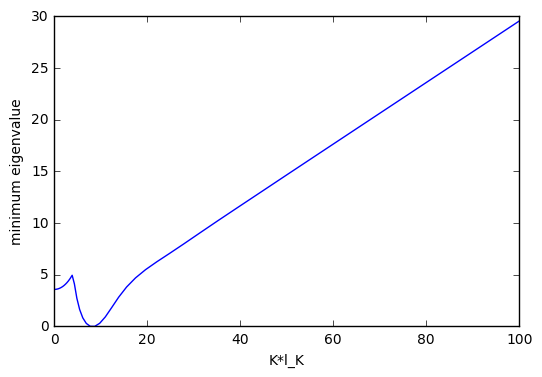

In [78]:
plt.plot(KV,eigValueList)
plt.xlabel('K*l_K')
plt.ylabel('minimum eigenvalue')
plt.show()

## Make Phase diagram

In [19]:
npts=100
FAs=np.linspace(0.1,0.9,npts)
chi_stars=np.zeros(npts)
def nearMelt(x,S,returnValues=False):   
    para={\
    'xAA':0.0,\
    'xAB':x,\
    'xBB':0.0,\
    'xl2':0.0,\
    'N':1.0,\
    'phiS':0.000001,\
    'vp':1.0,\
    'vs':1.0\
          }
    if returnValues:
        return para
    return lowestEig(S,para)
for ii in range(0,npts):
    if np.mod(ii,10)==0:
        print('working on ',ii,'of',npts)
    stuff = firstUnstable(nearMelt,FAs[ii],N,pset,display=False)
    chi_stars[ii]=stuff['chi'][0,1]*2.0

working on  0 of 100
working on  10 of 100
working on  20 of 100
working on  30 of 100
working on  40 of 100
working on  50 of 100
working on  60 of 100
working on  70 of 100
working on  80 of 100
working on  90 of 100


In [20]:
chi_starsMS=np.zeros(npts)
def nearMelt(x,S,returnValues=False):   
    para={\
    'xAA':0.0,\
    'xAB':x,\
    'xBB':0.0,\
    'xl2':-1.0,\
    'N':1.0,\
    'phiS':0.000001,\
    'vp':1.0,\
    'vs':1.0\
          }
    if returnValues:
        return para
    return lowestEig(S,para)
for ii in range(0,npts):
    if np.mod(ii,10)==0:
        print('working on ',ii,'of',npts)
    stuff = firstUnstable(nearMelt,FAs[ii],N,pset,display=False)
    chi_starsMS[ii]=stuff['chi'][0,1]*2.0

working on  0 of 100
working on  10 of 100
working on  20 of 100
working on  30 of 100
working on  40 of 100
working on  50 of 100
working on  60 of 100
working on  70 of 100
working on  80 of 100
working on  90 of 100


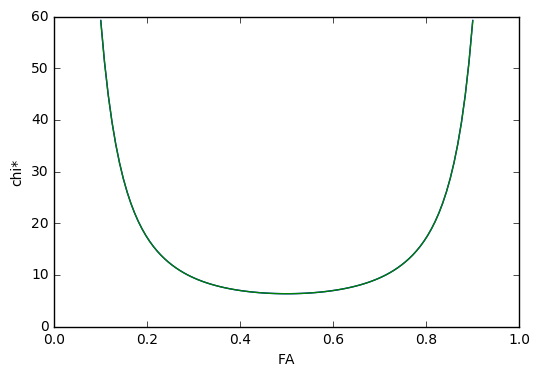

In [21]:
plt.plot(FAs,chi_stars,label='no MS')
xl2=nearMelt(0,0,True)['xl2']
plt.plot(FAs,chi_starsMS,label='MS='+str())
plt.xlim([0,1])
plt.xlabel('FA')
plt.ylabel('chi*')
plt.show()

# Pneumatic Transition 

In [68]:
def MSonly(x,S,returnValues=False):   
    para={\
    'xAA':0.0,\
    'xAB':0.0,\
    'xBB':0.0,\
    'xl2':-x,\
    'N':1.0,\
    'phiS':0.0001,\
    'vp':1.0,\
    'vs':1.0\
          }
    if returnValues:
        return para
    return lowestEig(S,para)

In [69]:
N=nearMelt(0,0,True)['N']
FA=0.5
stuff = firstUnstable(MSonly,FA,N,pset,display=True,guess=0.01)

K 0.001
chi
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -1.79928804 -1.79928804]
 [ 0.          0.         -1.79928804 -1.79928804]]
eigenValues
[  1.81721487e-10   1.12628472e+01   2.00020002e+04   1.45255968e+08]
eigenVector
[ -1.81713233e-12  -1.81713233e-12   7.07106781e-01   7.07106781e-01]
S
[[  2.49999999e-01   2.49999992e-01  -7.70920427e-10  -2.80003387e-09]
 [  2.49999992e-01   2.49999999e-01  -2.80003387e-09  -7.70920427e-10]
 [ -7.70920427e-10  -2.80003387e-09   1.13877059e-01   2.50806828e-02]
 [ -2.80003387e-09  -7.70920427e-10   2.50806828e-02   1.13877059e-01]]


In [70]:
npts=50
Ns=np.logspace(-1,4,npts)
MSstars=np.zeros(npts)

for ii in range(0,npts):
    if np.mod(ii,10)==0:
        print('working on ',ii,'of',npts)
    def nearMelt(x,S,returnValues=False):   
        para={\
        'xAA':0.0,\
        'xAB':0.0,\
        'xBB':0.0,\
        'xl2':-x,\
        'N':Ns[ii],\
        'phiS':0.000001,\
        'vp':1.0,\
        'vs':1.0\
              }
        if returnValues:
            return para
        return lowestEig(S,para)
    stuff = firstUnstable(nearMelt,FA,Ns[ii],pset,display=False)
    MSstars[ii]=stuff['x']

working on  0 of 50
working on  10 of 50
working on  20 of 50
working on  30 of 50
working on  40 of 50


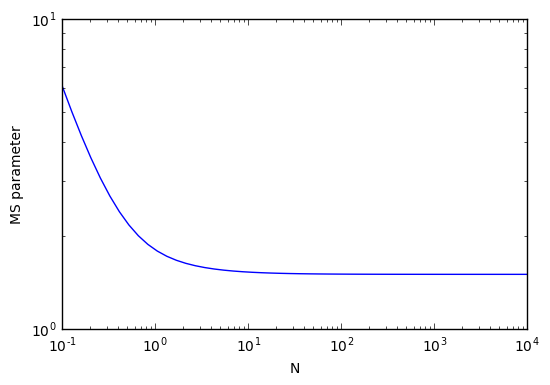

In [25]:
plt.loglog(Ns,MSstars)
plt.xlabel('N')
plt.ylabel('MS parameter')
plt.show()

# $\chi^*_{AB}$

In [ ]:
def neutral(x,S,returnValues=False):
    chiAS=0.0
    chiBS=0.0
    chiAB=x
    xl2=0.0
    xAA=-4*np.pi*chiAS
    xBB=-4*np.pi*chiBS
    xAB=2*np.pi*(chiAB-chiAS-chiBS)
    if returnValues:
        return xAA, xAB, xBB, xl2
    return lowestEig(xAB,xAA,xBB,xl2,S)

In [ ]:
pset=propagator.prop_set(nlam=5)
FA=0.75
N=10
stuff = firstUnstable(neutral,FA,N,pset,display=True)


In [ ]:
nFA=25
FAs=np.linspace(0.5,0.9,nFA)
chiS=np.zeros(nFA)
for ii in range(0,nFA):
    stuff = firstUnstable(neutral,FAs[ii],N,pset)
    chiS[ii]=stuff['chi'][0,1]

# Nematic transition

In [ ]:
nFA=25
FAs=np.linspace(0.5,0.9,nFA)
chi_MS=np.zeros(nFA)
xl2=-0.8
def funMS(x,S,returnValues=False):
    chiAS=0.0
    chiBS=0.0
    chiAB=x
    xAA=-4*np.pi*chiAS
    xBB=-4*np.pi*chiBS
    xAB=2*np.pi*(chiAB-chiAS-chiBS)
    if returnValues:
        return xAA, xAB, xBB, xl2
    return lowestEig(xAB,xAA,xBB,xl2,S)
for ii in range(0,nFA):
    stuff = firstUnstable(funMS,FAs[ii],N,pset)
    chi_MS[ii]=stuff['chi'][0,1]

In [ ]:
plt.plot(FAs,chiS,label='MS=0')
plt.plot(FAs,chi_MS,label='MS='+str(xl2))
plt.legend()
plt.xlabel('FA')
plt.show()

# Old

In [ ]:
nkpts=100
KV = np.logspace(-2,4,nkpts)
chiStars=np.zeros(nkpts)*np.NaN
FA=0.25
N=10
chiAS=0.0
chiBS=0.0
xl2=1.0

pset=propagator.prop_set(nlam=5)

for ii in range(0,nkpts):
    S=s2wlc_2(pset, N, FA, KV[ii])
    args=[chiAS,chiBS,xl2,S]
    chiStars[ii] = findZero(EigOf_xAB_neutral,args)

In [ ]:
plt.loglog(KV,chiStars)
plt.xlabel('K')
plt.ylabel('chi*')
plt.show()

In [ ]:
ii=np.argmin(chiStars)
chiStar=chiStars[ii]
K=KV[ii]
S=s2wlc_2(pset, N, FA, KV[ii])

In [ ]:
xAA=-4*np.pi*chiAS
xBB=-4*np.pi*chiBS
xAB=2*np.pi*(chiStar-chiAS-chiBS)
eigenValues, eigenVectors = getEigVV(S,xAB=xAB,xAA=xAA,xBB=xBB,xl2=xl2)
print('Chi Star')
print(chiStar)
print('K star')
print(K)
print('eigenValues')
print(eigenValues.real)
print('eigenVector')
print(eigenVectors[:,0].real)
print('Gamma')
print(getGam(S,xAB=xAB,xAA=xAA,xBB=xBB,xl2=xl2).real)

# Critical Nematic